In [37]:
import os, sys, time, resource, re, gc, shutil
from multiprocess import Pool
from functools import partial
from tabulate import tabulate
from urllib.parse import urlparse, parse_qsl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mongoengine.queryset.visitor import Q
import django
from django.db.models import Count
sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.models import *
from utils.text import *
from utils.plotting import *
from sklearn.feature_extraction.text import *
from sklearn.decomposition import NMF
from scipy.sparse import coo_matrix, find
from django.db.models import Q, F, Sum, Count, FloatField, Case, When

from run_id import run_id
run_id = 662
stat = RunStats.objects.get(pk=run_id)
q = stat.query
print(q.title)
from tmv_app.tasks import *
from utils.text import *

tokenize("the quick brown foxy fox jumped over the quite nice little lazy dog")

wos_all_updated


['the',
 'quick',
 'brown',
 'foxy',
 'fox',
 'jumped',
 'over',
 'the',
 'quite',
 'nice',
 'little',
 'lazy',
 'dog']

In [26]:
chapter = ""
ctitle = ""
ctext = ""
chapters = []
for wg in [1,2,3]:
    print(wg)
    f = "../data/ar6_wg{}.txt".format(wg)
    with open(f, "r") as file:
        for line in file:
            if "Chapter" in line:
                if ctitle != "":
                    chapters.append({
                        'wg':wg,
                        'chapter': chapter,
                        'ctitle': ctitle,
                        'ctext': ctext
                    })
                chapter = line.strip()
                ctitle = ""
                ctext = ""
                print(repr(line))
                continue
            if ctitle=="" and re.match('.*\w',line) is not None:
                ctitle = line
                print(ctitle)
                continue
            ctext = ctext + " " + line.strip()
        chapters.append({
            'wg':wg,
            'chapter': chapter,
            'ctitle': ctitle,
            'ctext': ctext
        })

1
'Chapter 1:\n'
Framing, context, methods

'Chapter 2:\n'
Changing state of the climate system

'Chapter 3:\n'
Human influence on the climate system

'Chapter 4:\n'
Future global climate: scenariobased projections and nearterm information

'Chapter 5:\n'
Global carbon and other biogeochemical cycles and feedbacks

'Chapter 6:\n'
Shortlived climate forcers

'Chapter 7:\n'
The Earth’

'Chapter 8:\n'
Water cycle changes

'Chapter 9:\n'
Ocean, cryosphere, and sea level change

'Chapter\n'
 10:

'Chapter 11:\n'
Weather and climate extreme events in a changing climate

'Chapter 12:\n'
Climate change information for regional impact and for risk assessment

2
'Chapter 1:\n'
  Point of departure and key concepts [30 pages]

'Chapter 2:\n'
  Terrestrial and freshwater ecosystems and their services [60 pages]

'Chapter 3:\n'
  Ocean and coastal ecosystems and their services [60 pages]

'Chapter 4:\n'
  Water [60 pages]

'Chapter 5:\n'
  Food, fibre, and other ecosystem products [60 pages]

'Chap

In [27]:
chapters

[{'chapter': 'Chapter 1:',
  'ctext': ' Executive Summary  Synthesis of key findings from AR5 and earlier assessment reports, and connections to AR6 Special Reports  Framing  of  the  physical  science  information  relev ant  for  mitigation,  adaptation,  and  risk assessment in the context of the Global Stocktake  Assessment approach  Observational and reanalysis developments since the AR5  Model and experimental design developments since the AR5  Emissions and forcing scenarios  Treatment and evaluation of uncertainty throughout the report Frequently Asked Questions',
  'ctitle': 'Framing, context, methods\n',
  'wg': 1},
 {'chapter': 'Chapter 2:',
  'ctext': ' Executive Summary  Multimillennial context, preindustrial to present day  Natural and anthropogenic forcings  Radiative forcing  Large-scale indicators of observed change in the atmosphere, ocean, cryosphere, land, and biosphere  Modes of variability Frequently Asked Questions',
  'ctitle': 'Changing state of the climate sys

In [49]:
stemmer = SnowballStemmer("english")

chapter_dict = []
    
def tokenize(text):
    transtable = {ord(c): None for c in string.punctuation + string.digits}
    tokens = nltk.word_tokenize(text.translate(transtable))
    tokens = [stemmer.stem(i) for i in tokens if len(i) > 2 and i not in stoplist]
    return tokens

ar6tops = Topic.objects.filter(run_id=run_id,year=6)
ar6tts = TopicTerm.objects.filter(run_id=run_id,topic__in=ar6tops)

for i,c in enumerate(chapters):
    for w in tokenize(c['ctext']):
        try:
            t = Term.objects.get(title=w)
        except:
            continue
        tts = ar6tts.filter(term=t)
        for tt in tts:
            t = tt.topic_id
            if t in c:
                chapters[i][t] = chapters[i][t]+tt.score
            else:
                chapters[i][t] = tt.score
    
    

In [51]:
cdf = pd.DataFrame.from_dict(chapters)

cdf.head()

,chapter,ctext,ctitle,wg,122471,122472,122473,122474,122475,122476,...,122566,122567,122568,122569,122570,122571,122572,122573,122574,122575
0,Chapter 1:,Executive Summary Synthesis of key findings ...,"Framing, context, methods\n",1,0.782658,2.262374,39.178989,3.562306,40.234780,47.437480,...,2.558380,5.484034,1.216050,0.950947,0.826648,4.725640,2.126555,34.430657,5.508276,13.131784
1,Chapter 2:,"Executive Summary Multimillennial context, p...",Changing state of the climate system\n,1,1.167327,0.366816,5.547630,0.737755,0.543509,2.903721,...,0.617634,0.499642,0.339648,0.057239,0.769899,0.278024,5.594333,0.963150,0.746376,1.627847
2,Chapter 3:,Executive Summary Overview of model perf orm...,Human influence on the climate system\n,1,1.170823,0.435124,7.175227,0.956058,0.358742,39.467883,...,1.681380,1.263578,0.658241,0.165210,1.516170,0.050177,4.645324,3.308175,0.861790,1.670389
3,Chapter 4:,Executive Summary Projections of global mean...,Future global climate: scenariobased projectio...,1,0.628125,1.153508,9.686454,4.210412,4.274992,10.666275,...,1.463356,1.744358,1.178863,0.842577,1.690122,1.677846,2.442248,38.213217,2.267943,19.215731
4,Chapter 5:,Executive Summary Feedbacks between clim...,Global carbon and other biogeochemical cycles ...,1,0.508464,1.123999,4.587729,1.019098,14.801188,14.205218,...,0.313940,1.194841,0.140283,0.392820,0.549082,1.176440,1.543385,10.402547,0.856550,0.928655


In [82]:
pcdf = pd.melt(
    cdf,
    id_vars = ('chapter','ctext','ctitle','wg'),
    var_name='topic',
    value_name='ar6_score'
)

tdf = pd.DataFrame.from_dict(
    list(ar6tops.values(
        'id','title','score'
    ))
).rename(columns={'id':'topic'})

pcdf = pcdf.merge(tdf)

pcdf.sort_values(['ctext','ar6_score'],ascending=False).head()

,chapter,ctext,ctitle,wg,topic,ar6_score,score,title
510,Chapter 7:,"s energy budget, climate feedbacks, and clima...",The Earth’\n,1,122483,75.486064,256.774882,"{climat, chang, impact}"
300,Chapter 7:,"s energy budget, climate feedbacks, and clima...",The Earth’\n,1,122478,23.843807,192.970489,"{energi, consumpt, renew}"
2148,Chapter 7:,"s energy budget, climate feedbacks, and clima...",The Earth’\n,1,122523,22.165468,160.160307,"{system, integr, perform}"
1938,Chapter 7:,"s energy budget, climate feedbacks, and clima...",The Earth’\n,1,122518,19.374857,140.883654,"{warm, global, permafrost}"
216,Chapter 7:,"s energy budget, climate feedbacks, and clima...",The Earth’\n,1,122476,15.956107,239.955846,"{model, simul, predict}"


In [89]:
def calculate_deviations(df):
    df['deviation'] = df['ipcc_share'] - df['share']
    df['abs_md'] = abs(df['deviation'])

    md = df['deviation'].max()
    rae = df['abs_md'].mean()
    lh = df['abs_md'].sum() / 2

    df['representation'] = df['ipcc_share'] / df['share']  
    
    df_disp = {'MD':md,'Rae':rae,'L-H':lh}
    return [df,df_disp]

tsums = pcdf[['title','topic','ar6_score']].groupby(['title','topic']).sum()

tsums = tsums.sort_values('ar6_score',ascending=False).reset_index().merge(tdf)

tsums['share'] = tsums['score'] / tsums['score'].sum()
tsums['ipcc_share'] = tsums['ar6_score'] / tsums['ar6_score'].sum()

df, df_disp = calculate_deviations(tsums)
df.sort_values('representation').head()

,title,topic,ar6_score,score,share,ipcc_share,deviation,abs_md,representation
90,"{plant, leaf, root}",122486,28.377035,141.220168,0.010571,0.001575,-0.008996,0.008996,0.148971
102,"{rice, paddi, straw}",122550,13.891815,65.488480,0.004902,0.000771,-0.004131,0.004131,0.157263
100,"{rainfal, monsoon, rain}",122521,20.060362,93.607239,0.007007,0.001113,-0.005894,0.005894,0.158877
80,"{soil, moistur, organ}",122472,44.437981,201.300114,0.015068,0.002466,-0.012602,0.012602,0.163660
103,"{wetland, marsh, restor}",122553,13.344251,59.553228,0.004458,0.000741,-0.003717,0.003717,0.166120


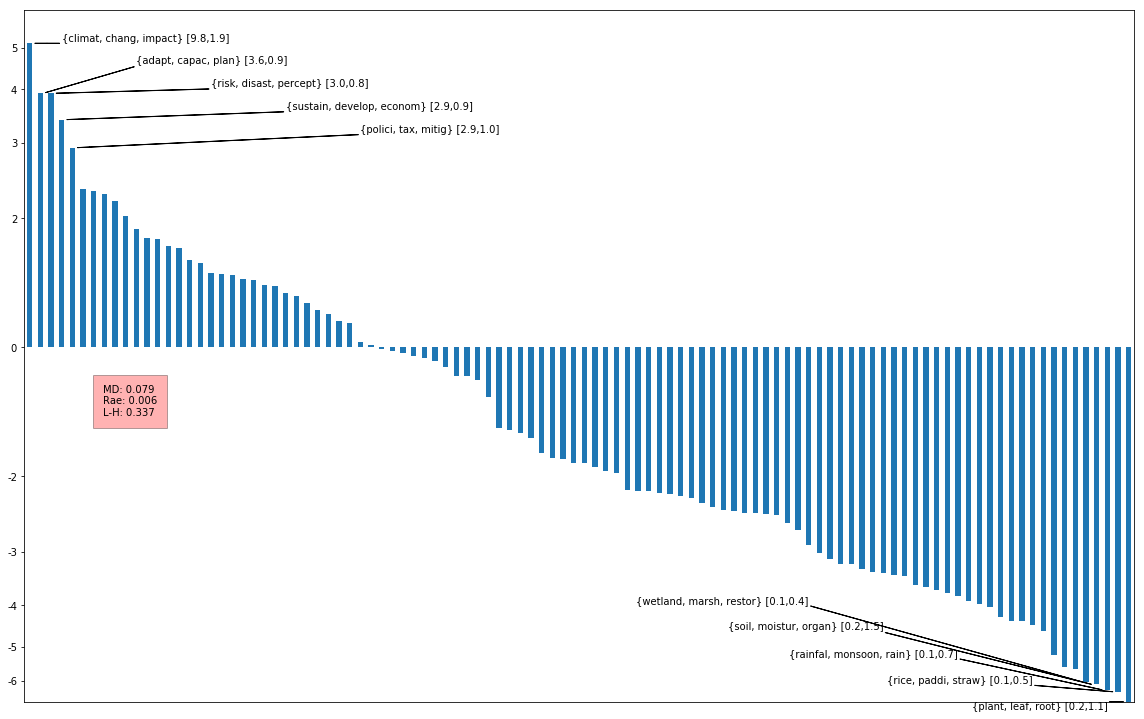

In [102]:
plt.rcParams["figure.figsize"] = [16,10]

def plot_representation(df, ax, nts=5, fmin=None, fmax=None):
    
    md = df['deviation'].max()
    rae = df['abs_md'].mean()
    lh = df['abs_md'].sum() / 2

    pdf = df.sort_values('representation',ascending=False).reset_index('title')

    pdf = pdf[pdf['share'] > 0.0001]

    pdf['lrep'] = np.log(pdf['representation'])
    #pdf['lrep'] = pdf['representation']
    pdf.set_index('title')['lrep'].plot(kind="bar",ax=ax)

    i = 0

    rmax = pdf['lrep'].max()
    if fmax:
        rmax = fmax
    rmin = pdf['lrep'].min()
    if fmin:
        rmin = -fmin
        
    xspace= 7
    xa = 4
    yspace = 0.075
    
    for index, row in pdf.head(nts).iterrows():
        i+=1
        s = round(row['ipcc_share']*100,1)
        v = round(row['share']*100,1)
        ax.annotate(
            s="{} [{},{}]".format(row['title'],s,v),
            xy=(-0.5+i,row['lrep']),
            xytext=(-xa+i*xspace,rmax-rmax*yspace*(i-1)),
            arrowprops=dict(
                facecolor='black', 
                #shrink=0.05,
                width=0.1,
                headwidth=0.2
            ),
            ha="left",
            va="bottom"
        )

    i = 0
    for index, row in pdf.sort_values('representation').head(nts).iterrows():
        i+=1
        s = round(row['ipcc_share']*100,1)
        v = round(row['share']*100,1)
        ax.annotate(
            s="{} [{},{}]".format(row['title'],s,v),
            xy=(len(pdf)-0.5-i,row['lrep']),
            xytext=(len(pdf)+xa-i*xspace,rmin-rmin*yspace*(i-1)),
            arrowprops=dict(
                facecolor='black', 
                #shrink=0.05,
                width=0.1,
                headwidth=0.2
            ),
            ha="right",
            va="top"
        )
        
    #ax.set_yscale('log')
    
    
    if rmin > -1:
        rmin = -1
    if np.exp(rmax) < 2:
        rmax = np.log(2.1)
    
    lmin = int(1/np.exp(rmin)//1)*-1
    lmax = int(np.exp(rmax)//1)
    


    ytick_labels = [i for i in range(lmin,lmax+1) if i not in [-1,1]]
    yticks = []
    for x in ytick_labels:
        if x < 0:
            y = np.log(-1/x)
        elif x==0:
            y = 0
        else:
            y = np.log(x)
        yticks.append(y)
    
    ax.set_yticks(yticks)
    ax.set_yticklabels(ytick_labels)
    
    #ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.1f"))
        
    rmax = pdf['lrep'].max()
    rmin = pdf['lrep'].min()
    
    ax.text(
        len(pdf)*0.066,-0.2,
        "MD: {:.3f}\nRae: {:.3f}\nL-H: {:.3f}".format(md,rae,lh),
        va="top",
        ha="left",
        bbox={'facecolor':'red', 'alpha':0.3,'pad':10}
   )

    #ax.text(1,-1*0.2,"MD: {:.3f}".format(md))   
    #ax.text(1,-1*0.4,"Rae: {:.3f}".format(rae))   
    #ax.text(1,-1*0.6,"L-H: {:.3f}".format(lh))   
    
    ax.get_xaxis().set_visible(False)#.set_ticks([])
    
    #ax.set_ylim((rmin+rmin*0.1,rmax+rmax*0.15))

fig, ax = plt.subplots()
plot_representation(df,ax,nts=5)
plt.tight_layout()
plt.savefig('../plots/ipcc_representation/ipcc_rep_{}_AR6.png'.format(run_id),bbox_inches='tight')

plt.show()

In [101]:
df[df['title']=="{biochar, amend, pyrolysi}"]

,title,topic,ar6_score,score,share,ipcc_share,deviation,abs_md,representation
95,"{biochar, amend, pyrolysi}",122512,24.313349,59.382892,0.004445,0.001349,-0.003096,0.003096,0.30354
